**Importing and setting up Tensorflow**

In [113]:
import tensorflow as tf
import os

In [114]:
gpus = tf.config.experimental.list_physical_devices('GPU')
# print(len(gpus))
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [115]:
print(gpus[0])

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


**Setting data paths and validating data**

In [116]:
import cv2
import imghdr

In [117]:
data_dir = 'data'
img_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [118]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in img_exts:
                print('Image not in extention list: {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image: {}'.format(image_path))

In [119]:
from matplotlib import pyplot as plt

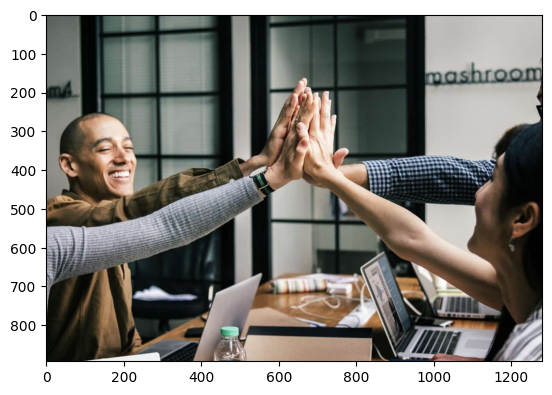

In [120]:
img = cv2.imread(os.path.join('data', 'happy', '7-Habits-of-Happy-People-image.jpeg'))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

**Loading Data**

In [121]:
tf.data.Dataset??

Init signature: tf.data.Dataset(variant_tensor)
Source:        
@tf_export("data.Dataset", v1=[])
class DatasetV2(
    collections_abc.Iterable,
    tracking_base.Trackable,
    composite_tensor.CompositeTensor,
    metaclass=abc.ABCMeta):
  """Represents a potentially large set of elements.

  The `tf.data.Dataset` API supports writing descriptive and efficient input
  pipelines. `Dataset` usage follows a common pattern:

  1. Create a source dataset from your input data.
  2. Apply dataset transformations to preprocess the data.
  3. Iterate over the dataset and process the elements.

  Iteration happens in a streaming fashion, so the full dataset does not need to
  fit into memory.

  Source Datasets:

  The simplest way to create a dataset is to create it from a python `list`:

  >>> dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
  >>> for element in dataset:
  ...   print(element)
  tf.Tensor(1, shape=(), dtype=int32)
  tf.Tensor(2, shape=(), dtype=int32)
  tf.Tensor(3, s

In [122]:
import numpy as np

In [123]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 148 files belonging to 2 classes.


In [124]:
data_iterator = data.as_numpy_iterator()

In [125]:
batch = data_iterator.next()

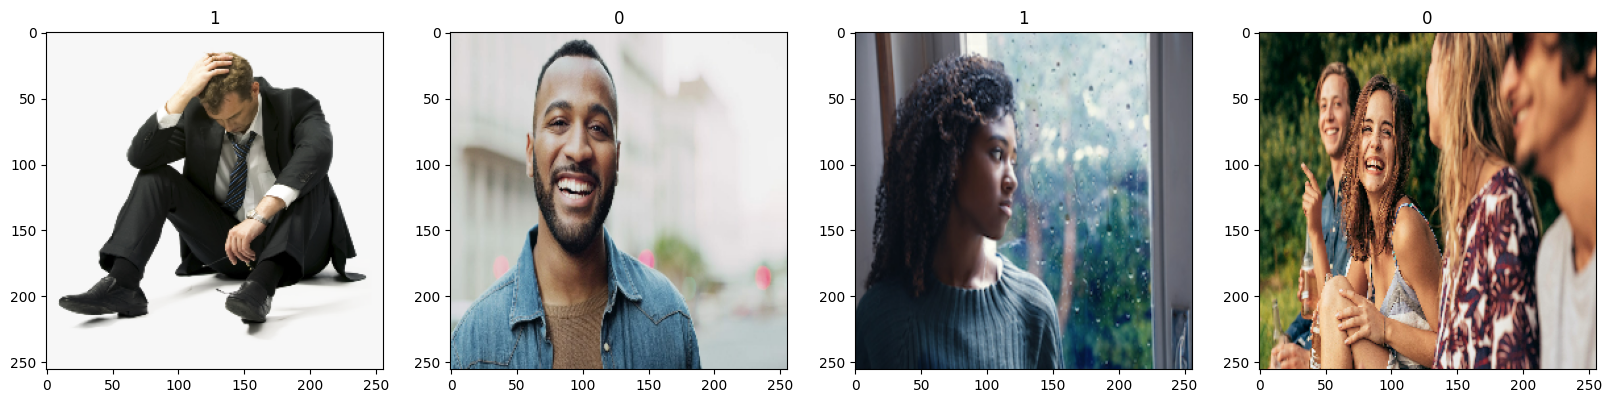

In [126]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

**Preprocess Data**

Scale Data

In [127]:
data = data.map(lambda x,y: (x/255, y))

In [128]:
scaled_iterator = data.as_numpy_iterator()

In [129]:
batch = scaled_iterator.next()

In [130]:
print(batch[0].max())

1.0


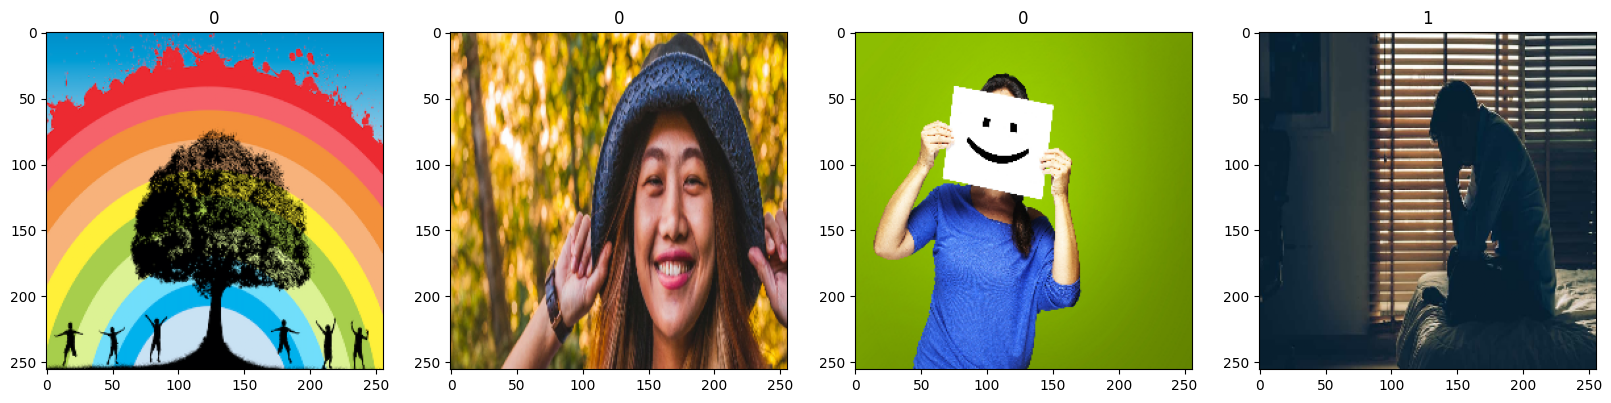

In [131]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

Split Data

In [132]:
len(data)

5

In [133]:
train_size = int(len(data)*.7)
val_size = int(len(data) * .2)
test_size = int(len(data) * .1) + 1

In [134]:
print(train_size)
print(val_size)
print(test_size)
print(train_size + val_size + test_size)

3
1
1
5


In [135]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

In [136]:
print(len(train))
print(len(val))
print(len(test))
print(len(train) + len(val) + len(test))

3
1
1
5


**Building the model**

In [137]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.optimizers.legacy import Adam

In [138]:
model = Sequential()

In [139]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [140]:
optimizer = Adam()

model.compile(optimizer=optimizer, loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [141]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 127, 127, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_18 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 30, 30, 16)      

**Training the model**

In [142]:
logdir = 'logs'

In [143]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [144]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
3/3 [==============================] - 2s 436ms/step - loss: 0.9009 - accuracy: 0.5104 - val_loss: 0.6949 - val_accuracy: 0.5312
Epoch 2/20
3/3 [==============================] - 2s 405ms/step - loss: 0.6731 - accuracy: 0.5938 - val_loss: 0.5549 - val_accuracy: 0.6562
Epoch 3/20
3/3 [==============================] - 2s 399ms/step - loss: 0.6504 - accuracy: 0.6146 - val_loss: 0.6123 - val_accuracy: 0.7500
Epoch 4/20
3/3 [==============================] - 2s 391ms/step - loss: 0.5959 - accuracy: 0.7812 - val_loss: 0.5488 - val_accuracy: 0.8438
Epoch 5/20
3/3 [==============================] - 1s 386ms/step - loss: 0.5307 - accuracy: 0.7292 - val_loss: 0.4902 - val_accuracy: 0.7188
Epoch 6/20
3/3 [==============================] - 2s 392ms/step - loss: 0.4695 - accuracy: 0.7812 - val_loss: 0.4212 - val_accuracy: 0.8438
Epoch 7/20
3/3 [==============================] - 2s 397ms/step - loss: 0.4053 - accuracy: 0.8750 - val_loss: 0.4049 - val_accuracy: 0.7812
Epoch 8/20
3/3 [====

**Plotting Performance**

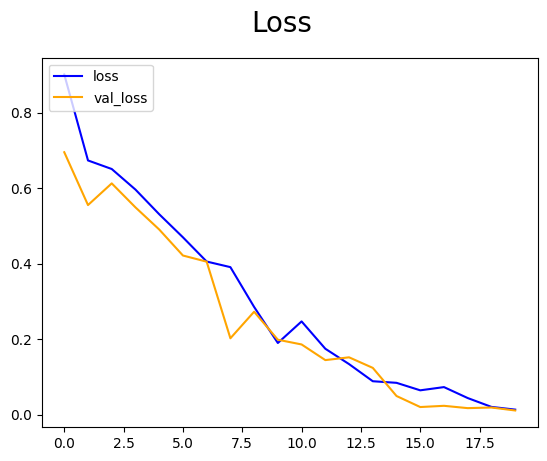

In [145]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='blue', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

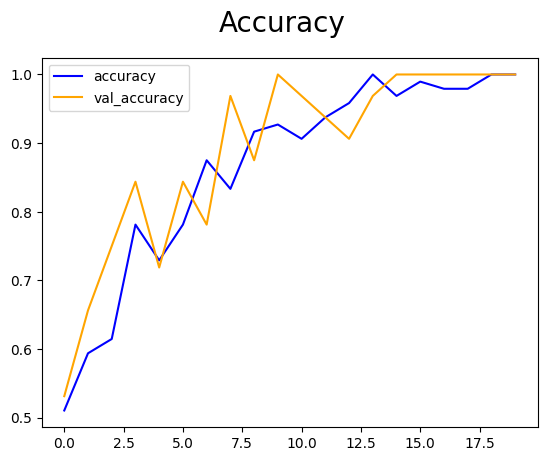

In [146]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='blue', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc='upper left')
plt.show()

**Evaluating Performance**

In [147]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [148]:
precision = Precision()
recall = Recall()
acc = BinaryAccuracy()

In [149]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    precision.update_state(y, yhat)
    recall.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 210ms/step


In [150]:
print(f'Precision: {precision.result().numpy()}')
print(f'Recall: {recall.result().numpy()}')
print(f'Accuracy: {acc.result().numpy()}')

Precision: 1.0
Recall: 1.0
Accuracy: 1.0


**Testing the model**

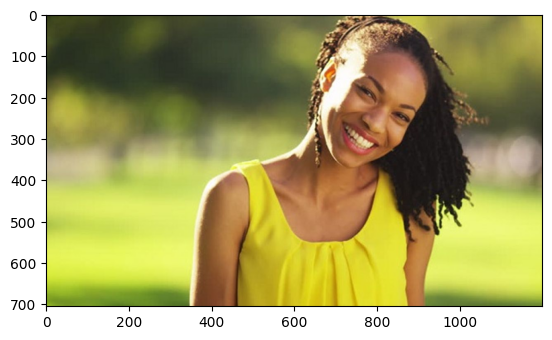

In [151]:
img = cv2.imread('happytest.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [152]:
def predict(imgpath):
    img = cv2.imread(imgpath)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    
    resize = tf.image.resize(img, (256, 256))
    
    yhat = model.predict(np.expand_dims(resize/255, 0))

    if yhat <= 0.5:
        print('This person is happy!')
    else:
        print('This person is sad...')

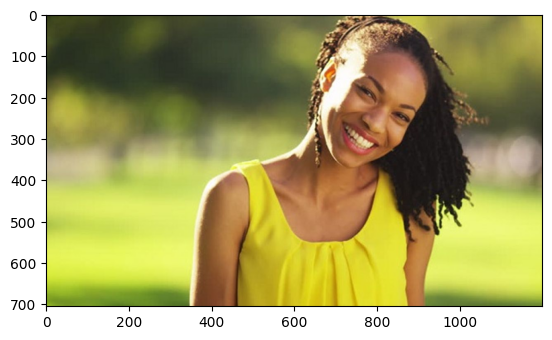

1/1 [==============================] - 0s 16ms/step
This person is sad...


In [155]:
predict('happytest.jpg')

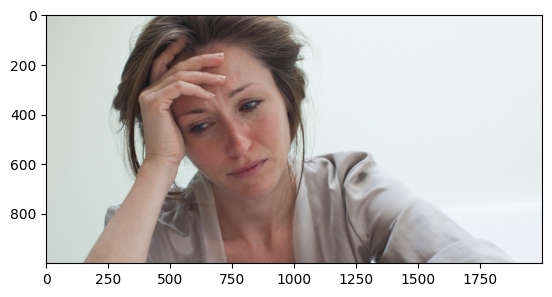

1/1 [==============================] - 0s 16ms/step
This person is sad...


In [156]:
predict('sadtest.jpg')

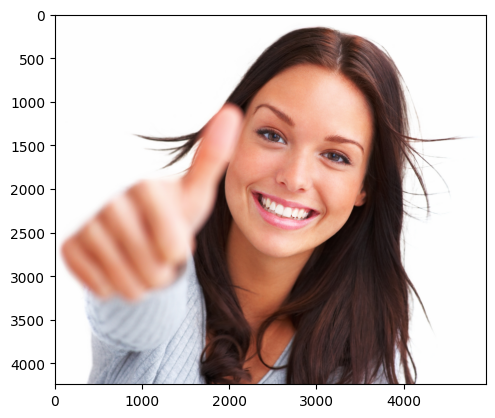

1/1 [==============================] - 0s 16ms/step
This person is happy!


In [158]:
predict('happytest2.jpg')

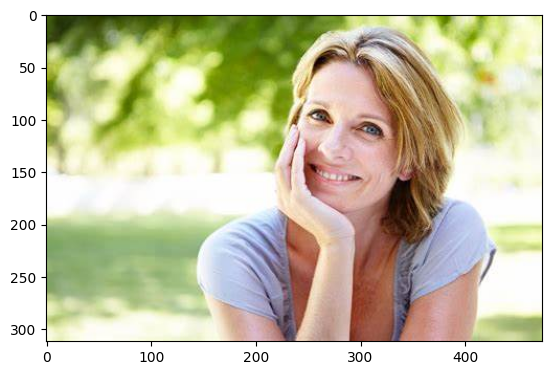

1/1 [==============================] - 0s 14ms/step
This person is happy!


In [161]:
predict('happytest3.jpg')

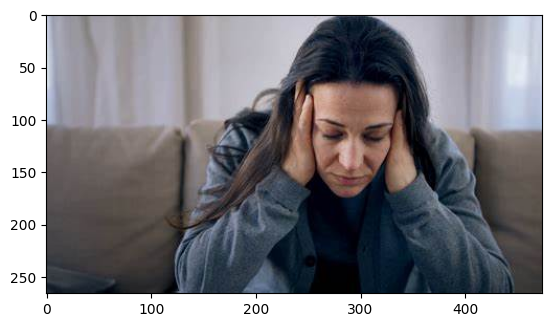

1/1 [==============================] - 0s 15ms/step
This person is sad...


In [162]:
predict('sadtest2.jpg')

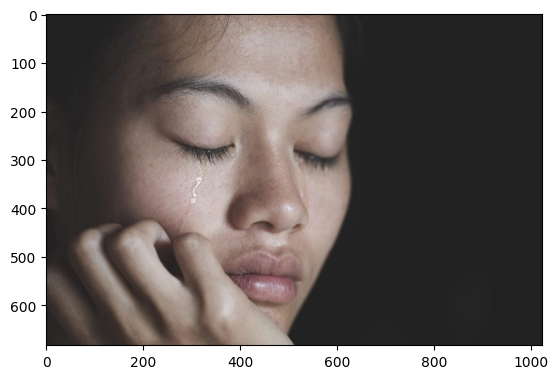

1/1 [==============================] - 0s 16ms/step
This person is sad...


In [163]:
predict('sadtest3.jpg')

**Saving the model**

In [164]:
from tensorflow.keras.models import load_model

In [165]:
model.save(os.path.join('models', 'happysadclassifier.h5'))